# Zonal Stats

By Cascade Tuholske, June 2020

Notebook to make rasters and stats for south FL. <br><br>
**NOTE** CRS should be epsg:4326 for everything!

In [1]:
#### Dependencies
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats, gen_zonal_stats
from glob import glob
import rasterio.mask
import matplotlib.pyplot as plt

In [2]:
#### File Paths & FNs
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'

## Clip Rasters

In [3]:
def raster_clip(rst_fn, polys):
    
    "function clips a raster and saves it out"
    
    # Get raster name
    data = rst_fn.split(DATA_PATH+'interim/')[1].split('_matched.tif')[0]
    fn_out = DATA_PATH+'interim/'+data+'_SouthFL.tif'
    print(fn_out)
    
    # clip raster
    with rasterio.open(rst_fn) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
        
    # Update meta data
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    # plot it
    plt.imshow(out_image[0])
    
    # write image 
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(out_image)

In [4]:
#### Open polys
polys_fn = DATA_PATH+'raw/South_FL/SouthFL.shp'
polys = gpd.read_file(polys_fn)
shapes = polys["geometry"]

In [5]:
#### Git tif files
rst_fns = glob('/Users/cascade/Github/PopGridCompare/data/interim/*_matched.tif')
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/GHS15_matched.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_matched.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_matched.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_matched.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_matched.tif']

/Users/cascade/Github/PopGridCompare/data/interim/GHS15_SouthFL.tif
/Users/cascade/Github/PopGridCompare/data/interim/LS15_SouthFL.tif
/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_SouthFL.tif
/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_SouthFL.tif
/Users/cascade/Github/PopGridCompare/data/interim/WP16_SouthFL.tif


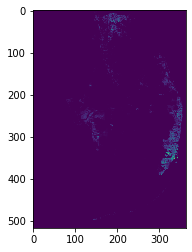

In [6]:
for rst_fn in rst_fns:
    raster_clip(rst_fn, shapes)

## Zonal Stats

In [7]:
#### Run on Nigeria GDAM 
polys_fn = DATA_PATH+'raw/South_FL/study_area_wgs84.shp'
polys = gpd.read_file(polys_fn)
col = 'GEOID' # gdam level
fn_out = DATA_PATH+'interim/South_FL_stats.shp' #updatea

In [8]:
# subset, be sure to check the admin level
polys = polys[['geometry', col]]

In [9]:
# Git tif files
rst_fns = glob('/Users/cascade/Github/PopGridCompare/data/interim/*_matched.tif')
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/GHS15_matched.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_matched.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_matched.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_matched.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_matched.tif']

In [10]:
def zone_loop(polys_in, rst_list, stats_type):
    """ Function loops through rasters, calcs zonal_stats and returns stats as a data frame.
    Args:
        polys_in = polygons
        rst_list = list of paths & fns of rasters
        stats_type = stats type for each poly gone (see zonal stats)
    """
    
    # copy polys to write out
    polys_out = polys_in.copy()
    
    for rst in rst_list:
        
        # Get data name
        data = rst.split(DATA_PATH+'interim/')[1].split('_matched.tif')[0]
        print('Started', data)
        
        # Run zonal stats
        zs_feats = zonal_stats(polys_in, rst, stats=stats_type, geojson_out=True)
        zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
        
        # Rename columns and merge
        zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
        
        polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')
    
    return polys_out


In [11]:
# Run zonal stats loop
polys_sum = zone_loop(polys, rst_fns, 'sum')
polys_sum.head()

Started GHS15
Started LS15
Started GPWv4
Started ESRI16
Started WP16


,geometry,GEOID,GHS15_sum,LS15_sum,GPWv4_sum,ESRI16_sum,WP16_sum
0,POLYGON ((-81.65759818781882 28.49245932407797...,1209593198,193868.584355,248285.0,195620.437500,231276.0,197838.453125
1,POLYGON ((-81.26431207196599 28.44867332377709...,1209590910,38140.738175,30531.0,38790.687500,49513.0,40333.136719
2,"POLYGON ((-81.65740018980451 28.5531833386954,...",1209593705,99218.275478,89858.0,100557.328125,112560.0,101692.031250
3,POLYGON ((-81.49881514576593 28.61414535753242...,1209592522,612005.965026,673996.0,617417.937500,704152.0,630493.187500
4,POLYGON ((-81.70939512676496 25.96409570166286...,1202191027,16113.665862,14625.0,16167.994141,15024.0,17052.830078


In [ ]:
#### merge
polys_fn = DATA_PATH+'raw/South_FL/study_area_wgs84.shp'
polys = gpd.read_file(polys_fn)

gpd_out = polys.merge(polys_sum.iloc[:,1:], on = 'GEOID', how = 'inner')

In [ ]:
gpd_out.head()

In [ ]:
#### Save it out
gpd_out = gpd.GeoDataFrame(polys_sum)
gpd_out.to_file(fn_out)

# Old Code

In [ ]:
#### Functions
def zonal_func(polys_in, rst_in, stats_type, save, fn_out = None):
    """ Runs zonal stats on a set of polygons for a given raster, see rasterstats for stats type.
    Returns geodata frame
    Args:
        polys = polygons as a shape file read into memory
        rst_fn = path to raster file to run zonal stats on
        stats_type = stats type for each poly gone (see zonal stats)
        save = True will save out a fail
        fn_out = file name and path to save out shape files
    """
    
    # Run Zonal Stats & Set to gpd df
    zs_feats = zonal_stats(polys_in, rst_in, stats=stats_type, geojson_out=True)
    zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
    
    if save == True:
        zgdf.to_file(fn_out) 
    
    return zgdf

In [ ]:
#### Run Zonal Stats
rst_fns = glob('/Users/cascade/Github/PopGridCompare/data/interim/*.tif')
fn_out = DATA_PATH+'interim/NGA_2_LS15.shp'
rst_fn = rst_fns[0]
zstats = zonal_func(polys, rst_fn, 'sum', save = True, fn_out =fn_out)